In [1]:
#imports
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import datetime as dt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.corpus import stopwords
from nltk import ngrams
from nltk.probability import FreqDist
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation, NMF
from dateutil import parser

In [2]:
def load_data():
    cwd = os.getcwd()
    df = pd.read_csv(cwd+"/cleaned-BA-reviews.csv", index_col=0)
    df = df.reset_index(drop=True)
    return df
df = load_data()


In [3]:
df.stars.mean()

4.738333810478099

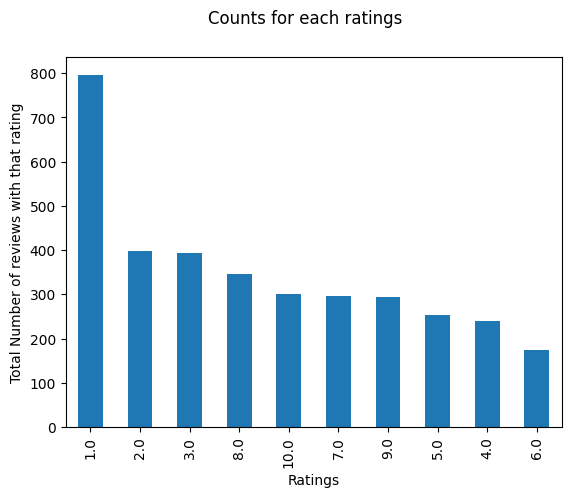

In [4]:
def visualize_ratings(df):
    df.stars.value_counts().plot(kind="bar")
    plt.xlabel("Ratings")
    plt.ylabel("Total Number of reviews with that rating")
    plt.suptitle("Counts for each ratings")
    plt.show()

visualize_ratings(df)


In [5]:
# Calculate rating distribution and percentage
df_ratings = df['stars'].value_counts().reset_index()
df_ratings.columns = ['Stars', 'total_counts']
df_ratings['pct_values'] = (df_ratings['total_counts'] / df_ratings['total_counts'].sum() * 100).round(2)
df_ratings = df_ratings.sort_values('Stars')

# Print the results
print(df_ratings)

   Stars  total_counts  pct_values
0    1.0           796       22.79
1    2.0           397       11.37
2    3.0           393       11.25
8    4.0           240        6.87
7    5.0           254        7.27
9    6.0           175        5.01
5    7.0           297        8.50
3    8.0           347        9.93
6    9.0           293        8.39
4   10.0           301        8.62


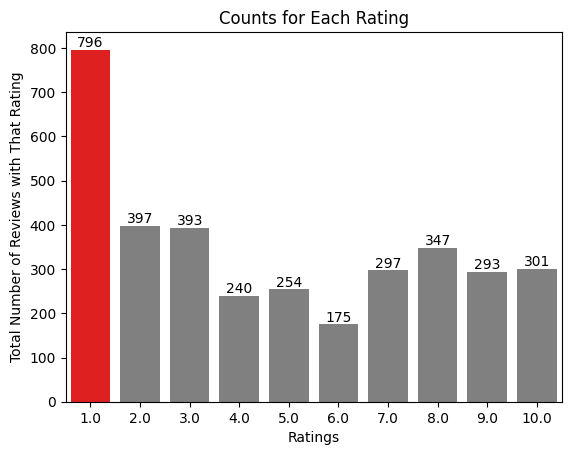

In [6]:
clrs = ['red' if x == df_ratings['total_counts'].max() else 'grey' for x in df_ratings['total_counts']]
ax = sns.barplot(x='Stars', y='total_counts', data=df_ratings, palette=clrs, errwidth=0)
for container in ax.containers:
    ax.bar_label(container)

ax.set_xlabel("Ratings")
ax.set_ylabel("Total Number of Reviews with That Rating")
ax.set_title("Counts for Each Rating")

plt.show()

In [7]:
# Unique countries BA recieved the reviews from

print(f"{len(df.country.unique())} unique countries")

69 unique countries


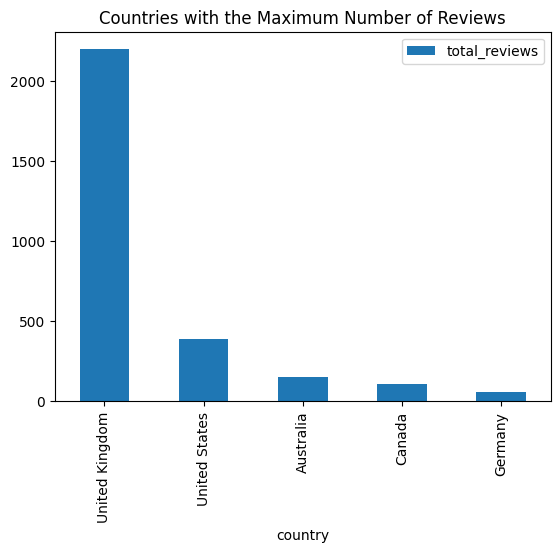

In [8]:
df_country_review = df['country'].value_counts().head().reset_index()
df_country_review.columns = ['country', 'total_reviews']

ax = df_country_review.plot(kind='bar', x='country', y='total_reviews')
plt.title('Countries with the Maximum Number of Reviews')

plt.show()


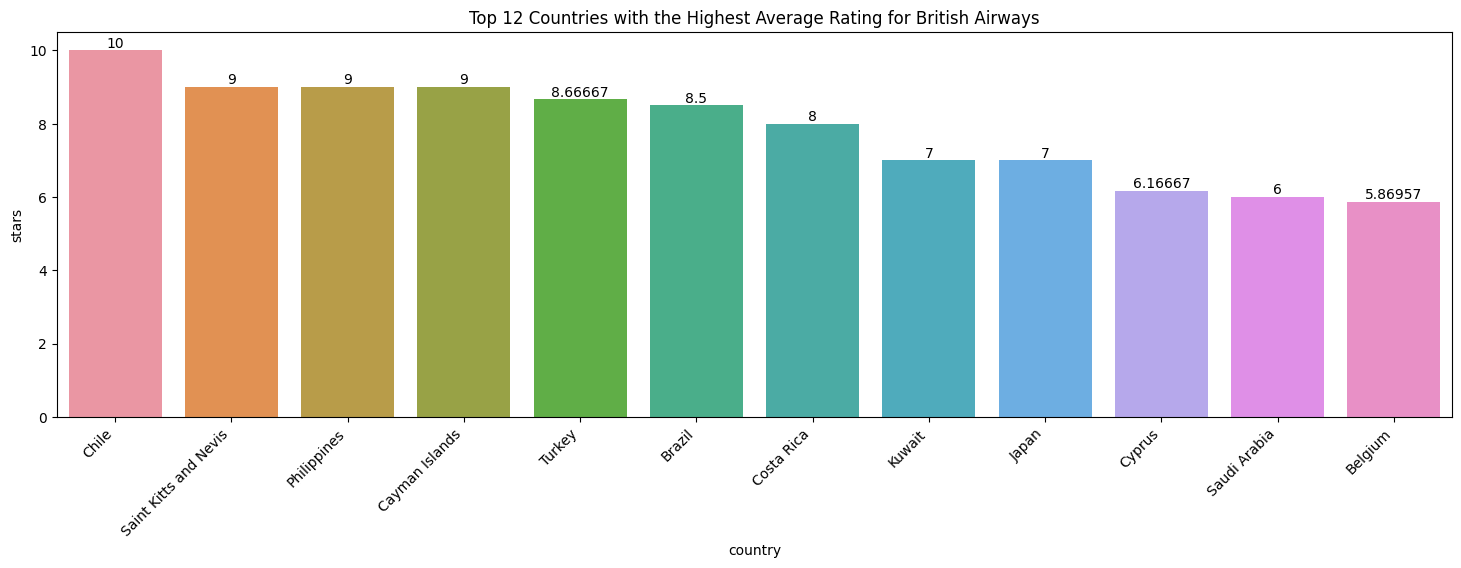

In [9]:
df_country_rating = df.groupby('country')['stars'].mean().sort_values(ascending=False).reset_index()
fig, ax = plt.subplots(figsize=(18, 5))
ax = sns.barplot(x='country', y='stars', data=df_country_rating[:12], ax=ax)

for container in ax.containers:
    ax.bar_label(container)
ax.set_title("Top 12 Countries with the Highest Average Rating for British Airways")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()


In [10]:
df = pd.read_csv('cleaned-BA-reviews.csv')
df['date'] = df['date'].apply(lambda x: parser.parse(x))

fig = px.line(df, x='date', y='stars')
fig.update_xaxes(rangeslider_visible=True)
fig.show()


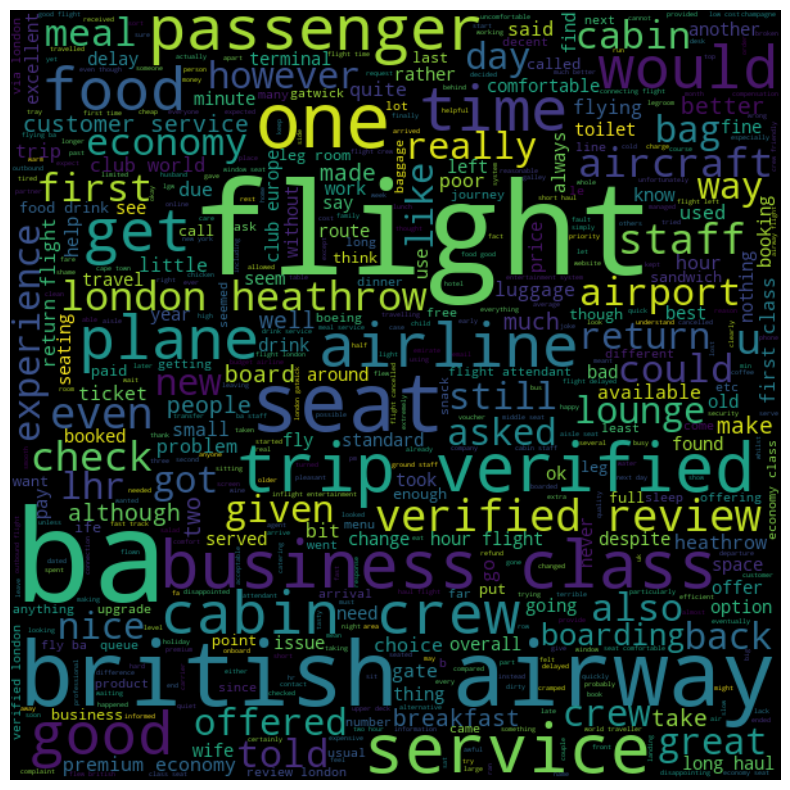

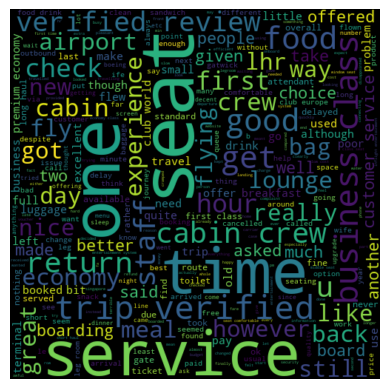

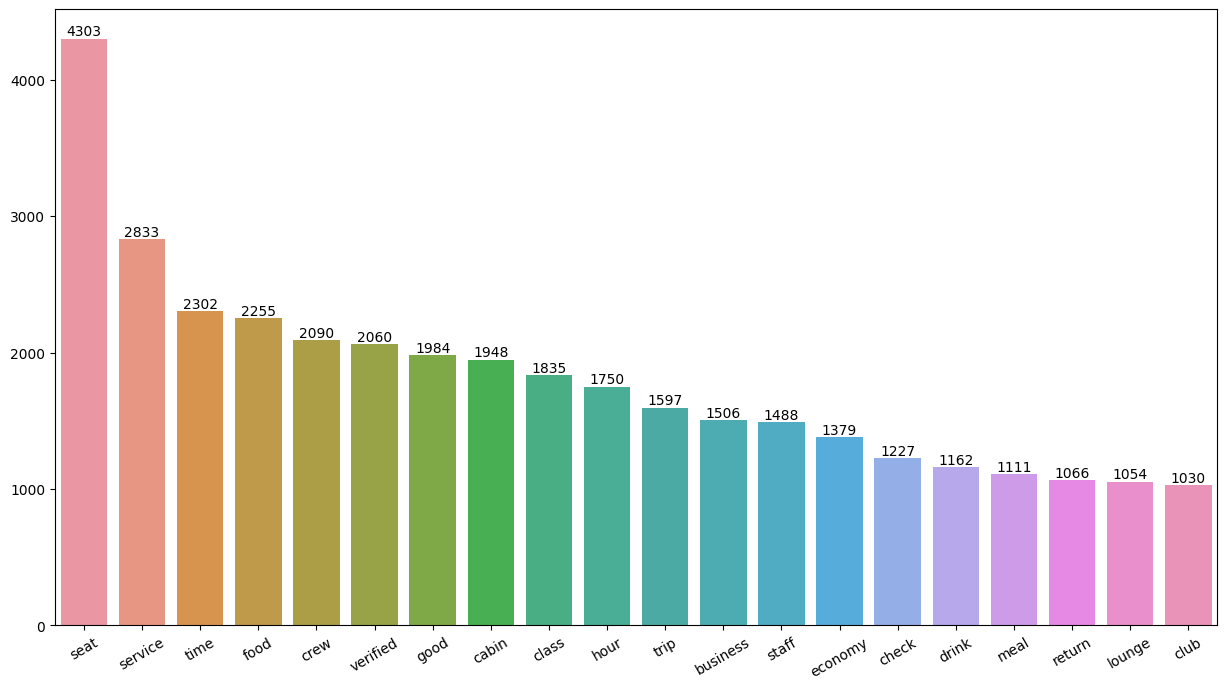

In [11]:
def analyze_word_frequencies(df):
    reviews = " ".join(df.corpus)
    plt.figure(figsize=(20,10))
    custom_stopwords = set(stopwords.words('english'))
    wordcloud = WordCloud(height=600, width=600, max_font_size=100, max_words=500, stopwords=custom_stopwords).generate(reviews)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    custom_stopwords.update(["ba", "flight", "british", "airway", "airline", "plane", "told", "also", "passenger",
                      "london", "heathrow", "aircraft", "could", "even", "would"])
    wordcloud = WordCloud(height=500, width=500, max_font_size=100, max_words=300, stopwords=custom_stopwords).generate(reviews)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    words = reviews.split(" ")
    custom_stopwords = text.ENGLISH_STOP_WORDS.union(['flight', 'ba', "passenger", "u", "london", "airway", "british",
                                               "airline", "heathrow", "plane", "lhr", "review"])
    new_words = [word for word in words if word not in custom_stopwords]
    nlp_words = FreqDist(new_words).most_common(20)
    all_fdist = pd.Series(dict(nlp_words))
    fig, ax = plt.subplots(figsize=(15,8))
    all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
    all_plot.bar_label(all_plot.containers[0])
    plt.xticks(rotation=30)
    plt.show()

analyze_word_frequencies(df)


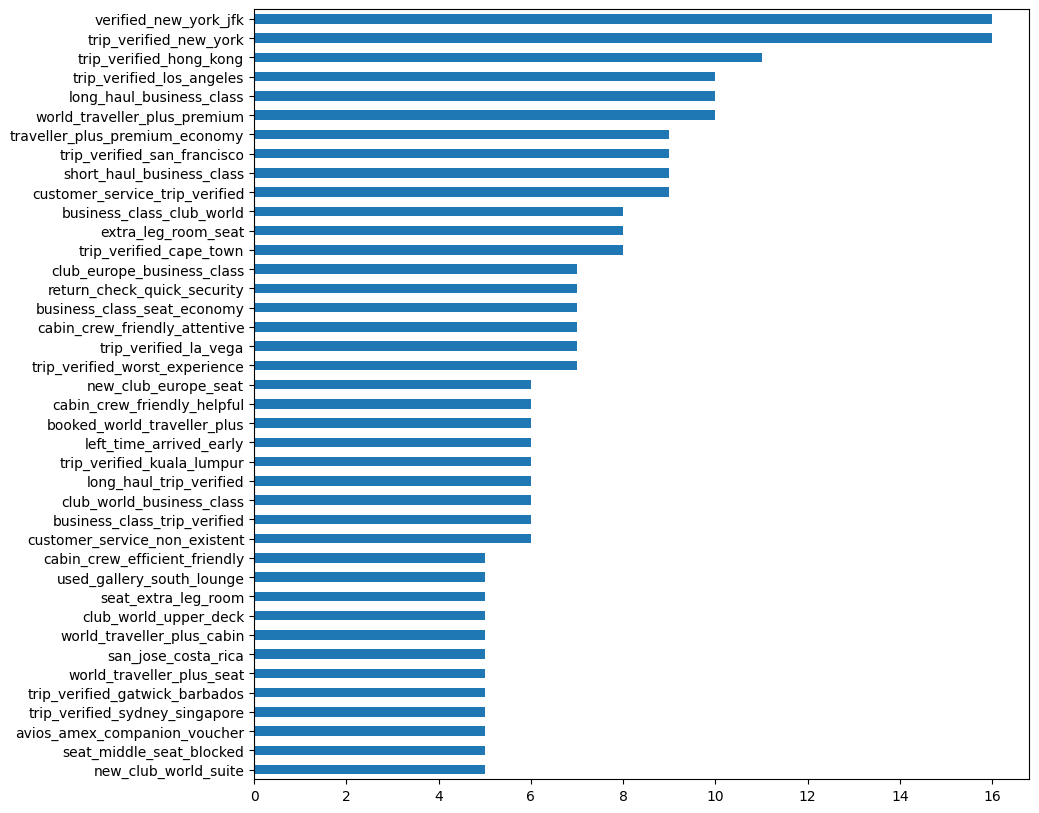

In [12]:
def get_freq_dist(words, number_of_ngrams):
    ngrams_list = ngrams(words, number_of_ngrams)
    ngram_fd = FreqDist(ngrams_list).most_common(40)
    ngram_sorted = {k: v for k, v in sorted(ngram_fd, key=lambda item: item[1])}
    ngram_joined = {'_'.join(k): v for k, v in sorted(ngram_fd, key=lambda item: item[1])}
    ngram_freqdist = pd.Series(ngram_joined)
    plt.figure(figsize=(10, 10))
    ax = ngram_freqdist.plot(kind="barh")
    return ax

def analyze_ngrams(df):
    reviews = " ".join(df.corpus)
    words = reviews.split(" ")
    custom_stopwords = text.ENGLISH_STOP_WORDS.union(['flight', 'ba', "passenger", "u", "london", "airway", "british",
                                               "airline", "heathrow", "plane", "lhr", "review"])
    new_words = [word for word in words if word not in custom_stopwords]
    ax = get_freq_dist(new_words, 4)
    plt.show()


analyze_ngrams(df)


In [13]:

def perform_sentiment_analysis(df):
    polarity_scores = []
    
    for text in df['corpus']:
        sentiment = TextBlob(text)
        polarity_scores.append(sentiment.sentiment.polarity)
    
    df['polarity'] = polarity_scores
    
    print(f"{df[(df['polarity'] > -0.2) & (df['polarity'] < 0.2)].shape[0]} number of reviews between -0.2 and 0.2 polarity score")
    print(f"{df[(df['polarity'] > -0.1) & (df['polarity'] < 0.1)].shape[0]} number of reviews between -0.1 and 0.1 polarity score")

perform_sentiment_analysis(df)


2355 number of reviews between -0.2 and 0.2 polarity score
1367 number of reviews between -0.1 and 0.1 polarity score


In [14]:

def perform_sentiment_analysis(df):
    sia = SentimentIntensityAnalyzer()
    sentiment_labels = []

    for text in df['corpus']:
        sentiment = sia.polarity_scores(text)
        compound_score = sentiment['compound']
        
        if compound_score > 0:
            sentiment_labels.append(1)  
        elif compound_score < 0:
            sentiment_labels.append(-1) 
        else:
            sentiment_labels.append(0)  

    df['sentiment_label'] = sentiment_labels

    print(f"{df[df['sentiment_label'] == 1].shape[0]} positive reviews")
    print(f"{df[df['sentiment_label'] == 0].shape[0]} neutral reviews")
    print(f"{df[df['sentiment_label'] == -1].shape[0]} negative reviews")

perform_sentiment_analysis(df)


2344 positive reviews
20 neutral reviews
1129 negative reviews


In [15]:
def perform_topic_modeling(df):
    count_vectorizer = CountVectorizer()
    count_matrix = count_vectorizer.fit_transform(df['corpus'])
    count_feature_names = list(count_vectorizer.vocabulary_.keys())
    
    number_of_topics = 8
    model = LatentDirichletAllocation(n_components=number_of_topics, random_state=0)
    model.fit(count_matrix)
    
    topic_dict = {}
    for topic_idx, topic in enumerate(model.components_):
        topic_dict[f"Topic {topic_idx} words"] = [count_feature_names[i] for i in topic.argsort()[:-10 - 1:-1]]
        topic_dict[f"Topic {topic_idx} weights"] = ['{:.1f}'.format(topic[i]) for i in topic.argsort()[:-10 - 1:-1]]
    
    df_topic = pd.DataFrame(topic_dict)
    return df_topic

df_topic = perform_topic_modeling(df)
print(df_topic)


  Topic 0 words Topic 0 weights Topic 1 words Topic 1 weights Topic 2 words  \
0    forcefully           180.6         known           118.6    forcefully   
1       artisan           144.4         weigh           109.4     confirmed   
2     utilising           135.5       galling            94.6     literally   
3      eighteen           117.4       artisan            91.1           pcr   
4       reverts           103.1         perth            75.2         known   
5         today            99.1       ceiling            68.8       artisan   
6    occurrence            97.6      monitory            67.1      restroom   
7           pcr            81.2     confirmed            65.6         perth   
8       galling            76.8         today            52.0      monitory   
9       enquire            66.5   consolation            47.8       leading   

  Topic 2 weights Topic 3 words Topic 3 weights Topic 4 words Topic 4 weights  \
0          1622.9         known           395.0  

In [19]:

def perform_topic_modeling(df):
    vectorizer = CountVectorizer()
    count_matrix = vectorizer.fit_transform(df['corpus'])

    number_of_topics = 2

    nmf_model = NMF(n_components=number_of_topics, init='random', random_state=0)
    nmf_features = nmf_model.fit_transform(count_matrix)
    nmf_components = nmf_model.components_

    feature_names = vectorizer.get_feature_names_out()

    def get_top_words(topic, n_top_words):
        return [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]

    topic_dict = {}
    for topic_idx, topic in enumerate(nmf_components):
        topic_dict[f"Topic {topic_idx} words"] = get_top_words(topic, 10)
        topic_dict[f"Topic {topic_idx} weights"] = ['{:.1f}'.format(nmf_components[topic_idx][i]) for i in topic.argsort()[:-10 - 1:-1]]

    df_topic = pd.DataFrame(topic_dict)
    return df_topic

df_topic = perform_topic_modeling(df)
print(df_topic)


  Topic 0 words Topic 0 weights Topic 1 words Topic 1 weights
0          seat            21.3        flight            21.9
1            ba            11.4            ba             7.4
2         class             9.1          hour             4.8
3          food             7.3          time             4.2
4      business             7.1        london             3.9
5       service             7.0       service             3.7
6         cabin             6.8        airway             3.6
7          good             6.3       british             3.5
8          crew             6.2         would             3.2
9       economy             5.8      verified             3.1
